## Experiment 2 (semantic priming)

Our experiment 2 was based on the first experiment in:

Besner, D., Smith, M. C., & MacLeod, C. M. (1990). Visual word recognition: A dissociation of lexical and semantic processing. _Journal of Experimental Psychology: Learning, Memory, and Cognition, 16_(5), 862.

If we find the same results that they did, our results should look something like the results reported in their Table 1:

<img src="https://github.com/ethanweed/ExPsyLing/blob/master/Slides/Images/Besner%20et%20al_1990_Table%201.png?raw=true" width=""/>


In [1]:


#%pip install jsonlines

import jsonlines
import pandas as pd
import pingouin as pg
import seaborn as sns
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')



In [3]:

# convert data json blob to csv

# the code in this cell comes from michedini and their post at:
# https://forum.cogsci.nl/discussion/8257/problem-with-jatos-result-conversion

raw = '/Users/ethan/Documents/GitHub/ExPsyLing/Experiments/Experiment2/data/semantic-relatedness_2023.txt'
pathout = '/Users/ethan/Documents/GitHub/ExPsyLing/Experiments/Experiment2/data/data.csv'

i = 0

with jsonlines.open(raw) as reader:
    for line in reader:
        if i == 0:
            df = pd.DataFrame(line)
            i += 1
        else:
            df = pd.concat([df, pd.DataFrame(line)])
            i += 1

df['url'] = df['url'].ffill()
df['url'] = [int(x['srid']) for x in list(df['url'])]
del df['meta']

df.to_csv(pathout)

In [4]:
# read in the data

raw = pd.read_csv('/Users/ethan/Documents/GitHub/ExPsyLing/Experiments/Experiment2/data/data.csv')

In [5]:
# some preprocessing


df = raw[raw['sender'] == 'Stimulus']                               # get only rows with RT data
df = df[df['correct'] == True]                                      # get only correct responses

data = df[['sender', 'url', 'duration', 'condition']].copy()        # get only the columns we need


data_agg = df.groupby(['url', 'condition']).mean().reset_index()    # get aggregated data (RT means per participant per condition)
data_agg.head()


,url,condition,Unnamed: 0,duration,time_run,time_render,time_show,time_end,time_commit,time_switch,counterbalance,Unnamed: 17
0,2225,Filler,188.600000,742.948000,115093.915000,115089.456000,115106.122000,115849.070000,115852.340000,115868.591500,1.0,NaN
1,2225,Nonword,166.200000,704.715200,105423.140000,105419.033800,105435.699800,106140.415000,106145.090000,106160.670800,1.0,NaN
2,2225,Related,164.545455,598.352455,105002.818182,104998.227000,105014.893000,105613.245455,105616.427273,105632.292545,1.0,NaN
3,2225,Unrelated,153.500000,757.481125,100174.556250,100170.590375,100187.256375,100944.737500,100948.012500,100963.267000,1.0,NaN
4,2226,Filler,213.250000,640.613000,125703.037500,125700.021000,125716.687000,126357.300000,126364.425000,126377.077250,1.0,NaN


<Axes: xlabel='condition', ylabel='duration'>

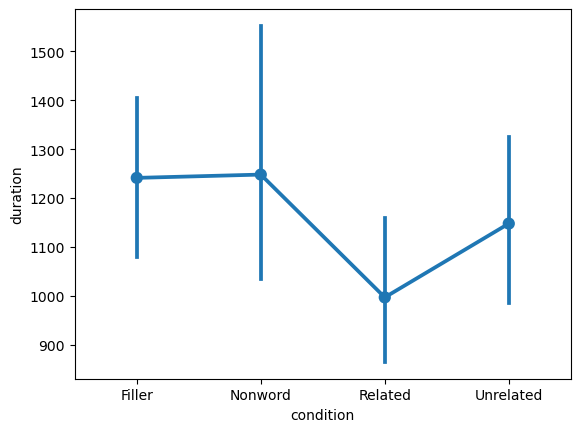

In [6]:
# inspect the data

sns.pointplot(data = data_agg, x='condition', y = 'duration')

In [35]:
# Remove filler trials
data_agg = data_agg[data_agg['condition'] != 'Filler']

<Axes: xlabel='condition', ylabel='duration'>

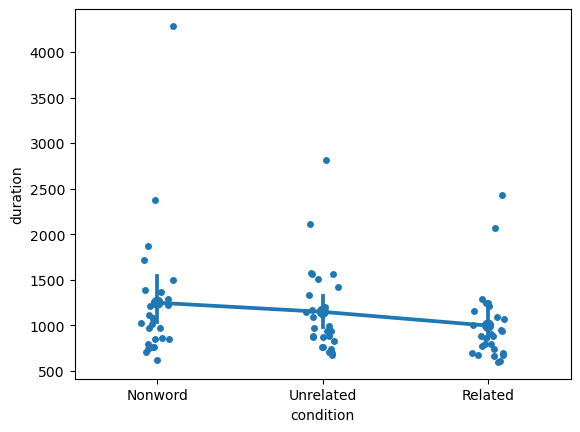

In [50]:
# Look at the means together with the actual datapoints

order = ['Nonword', 'Unrelated', 'Related']                                     # define the order we want the x-axis categories to have
sns.pointplot(data = data_agg, x='condition', y = 'duration', order=order)
sns.stripplot(data = data_agg, x='condition', y = 'duration', order=order)

<Axes: xlabel='condition', ylabel='duration'>

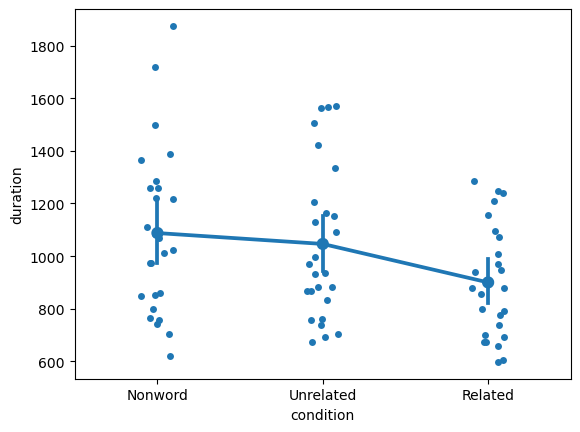

In [54]:
# Remove outliers

# looking at boxplots is one way to identify outliers
#sns.boxplot(data = data_agg, x='condition', y = 'duration', order=order)

# get only RT's less than 2 seconds
data_agg = data_agg[data_agg['duration'] < 2000]

order = ['Nonword', 'Unrelated', 'Related']
sns.pointplot(data = data_agg, x='condition', y = 'duration', order=order)
sns.stripplot(data = data_agg, x='condition', y = 'duration', order=order)

In [66]:
# Repeated-measures ANOVA
# pingouin prefers (requires, I think) the full, non-aggregated dataset for ANOVA, so we'll go back to that 
data = data[data['condition'] != 'Filler']          # remove filler trials from full dataset

pg.rm_anova(data=data[data['duration'] < 2000], within='condition', subject='url', dv = 'duration')     # rm ANOVA after removing outliers

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,condition,2,54,5.082738,0.009495,0.026863,0.041616,0.577301,False,0.267801,3.643858e-08


Some sanity checks

In [71]:
# Number of participants
len(data[data['duration'] < 2000]['url'].unique())

28

In [72]:
# ddof1 = number of conditions -1
len(data['condition'].unique()) -1

2

In [73]:

# ddof2 = N-1 * number of conditions
(len(data['url'].unique()) - 1) * (len(data['condition'].unique())-1)

54

In [81]:
# Family-wise error rate

alpha = 0.05
number_of_compairisons = 3

fwer = 1-((1-alpha)**number_of_compairisons)
print('Family-wise error rate:', round(fwer, 4))



Family-wise error rate: 0.1426


In [85]:
pg.pairwise_tests(data=data, dv='duration', between=None, within='condition', subject='url', alpha=0.05, alternative='two-sided', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,Nonword,Related,True,True,3.766386,27.0,two-sided,0.000818,0.002455,bonf,40.267,0.426541
1,condition,Nonword,Unrelated,True,True,1.221283,27.0,two-sided,0.232536,0.697609,bonf,0.392,0.163416
2,condition,Related,Unrelated,True,True,-4.024971,27.0,two-sided,0.000414,0.001243,bonf,73.637,-0.334434


In [8]:
raw.correct.value_counts()

True     2094
False     222
Name: correct, dtype: int64

In [9]:
list(df)

['Unnamed: 0',
 'url',
 'sender',
 'sender_type',
 'sender_id',
 'response',
 'response_action',
 'ended_on',
 'duration',
 'time_run',
 'time_render',
 'time_show',
 'time_end',
 'time_commit',
 'timestamp',
 'time_switch',
 'counterbalance',
 'Unnamed: 17',
 'stim',
 'condition',
 'block',
 'correct_response',
 'correctResponse',
 'correct']